## Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

## Load Data

In [2]:
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/data_retail.csv', sep=';')
df.head()

,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jaket,1466304274396,1538718482608,1467681,22
1,2,2,29531,Sepatu,1406077331494,1545735761270,1269337,41
2,3,3,141526,Tas,1493349147000,1548322802000,310915,30
3,4,4,141526,Jaket,1493362372547,1547643603911,722632,27
4,5,5,37545,Sepatu,1429178498531,1542891221530,1775036,25


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   no                          100000 non-null  int64 
 1   Row_Num                     100000 non-null  int64 
 2   Customer_ID                 100000 non-null  int64 
 3   Product                     100000 non-null  object
 4   First_Transaction           100000 non-null  int64 
 5   Last_Transaction            100000 non-null  int64 
 6   Average_Transaction_Amount  100000 non-null  int64 
 7   Count_Transaction           100000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 6.1+ MB


- Total rows : 1000000
- Total column : 8

## Exploratory Data Analysis

Two columns show the transactions are not of type datetime, these columns will be converted to datetime type

In [4]:
# Kolom First_Transaction
df['First_Transaction'] = pd.to_datetime(df['First_Transaction']/1000, unit='s', origin='1970-01-01')
# Kolom Last_Transaction
df['Last_Transaction'] = pd.to_datetime(df['Last_Transaction']/1000, unit='s', origin='1970-01-01')

In [5]:
df.head()

,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jaket,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040,1467681,22
1,2,2,29531,Sepatu,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981,1269337,41
2,3,3,141526,Tas,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000,310915,30
3,4,4,141526,Jaket,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013,722632,27
4,5,5,37545,Sepatu,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970,1775036,25


## Check Null and Missing Values

In [6]:
df.isna().sum()

no                            0
Row_Num                       0
Customer_ID                   0
Product                       0
First_Transaction             0
Last_Transaction              0
Average_Transaction_Amount    0
Count_Transaction             0
dtype: int64

no one of data is null

## Check duplicated Values

In [7]:
df.duplicated().sum()

0

no duplicate data

## Churn Customers

To determine churn customers according to the definition given, look for the most recent transaction when it was done, classify which customers have churn status and which are not.

In [8]:
# Pengecekan transaksaksi terakhir dalam dataset
print(max(df['Last_Transaction']))

# Klasifikasikan customer yang berstatus churn atau tidak dengan boolean
df.loc[df['Last_Transaction'] <= '2018-08-01', 'is_churn'] =True
df.loc[df['Last_Transaction'] > '2018-08-01', 'is_churn'] = False
df.head()

2019-02-01 23:57:57.286000013


,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction,is_churn
0,1,1,29531,Jaket,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040,1467681,22,False
1,2,2,29531,Sepatu,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981,1269337,41,False
2,3,3,141526,Tas,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000,310915,30,False
3,4,4,141526,Jaket,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013,722632,27,False
4,5,5,37545,Sepatu,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970,1775036,25,False


last transaction on ! Feb 2019. Customers is churn if they do not make transactions in the last 6 months (1 August 2018-1 Feb 2019)

In [9]:
df['is_churn'] = df['is_churn'].astype(int)

In [10]:
df['is_churn'].value_counts()

1    66569
0    33431
Name: is_churn, dtype: int64

Based on the results above, it can be seen that the number of customers who churn and those who do not churn are not balanced.

In [11]:
# Hapus kolom-kolom yang tidak diperlukan
del df['no']
del df['Row_Num']
df.head()

,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction,is_churn
0,29531,Jaket,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040,1467681,22,0
1,29531,Sepatu,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981,1269337,41,0
2,141526,Tas,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000,310915,30,0
3,141526,Jaket,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013,722632,27,0
4,37545,Sepatu,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970,1775036,25,0


### Customer acquisition by year

Next, we want to look at the trend of acquisition by year. For that, we create additional columns which are the year of First_Transaction and year of Last_Transaction respectively named Year_First_Transaction and Year_Last_Transaction before visualizing.

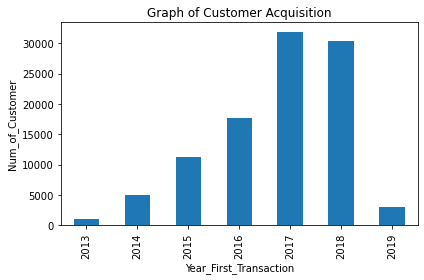

In [12]:
import matplotlib.pyplot as plt

# Kolom tahun transaksi pertama
df['Year_First_Transaction'] = df['First_Transaction'].dt.year
# Kolom tahun transaksi terakhir
df['Year_Last_Transaction'] = df['Last_Transaction'].dt.year

df_year = df.groupby(['Year_First_Transaction'])['Customer_ID'].count()
df_year.plot(x='Year_First_Transaction', y='Customer_ID', kind='bar', title='Graph of Customer Acquisition')
plt.xlabel('Year_First_Transaction')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()

total customers who transact increases every year, then total customer decreases slightly in 2018 and 2019.

### Transaction by year

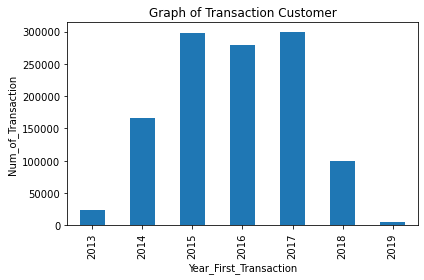

In [13]:
import matplotlib.pyplot as plt

plt.clf()
df_year = df.groupby(['Year_First_Transaction'])['Count_Transaction'].sum()
df_year.plot(x='Year_First_Transaction', y='Count_Transaction', kind='bar', title='Graph of Transaction Customer')
plt.xlabel('Year_First_Transaction')
plt.ylabel('Num_of_Transaction')
plt.tight_layout()
plt.show()

transactions tends to increase until 2017 and decreases in 2018 and 2019

### Average transaction amount by year

average number of transactions for each product per year

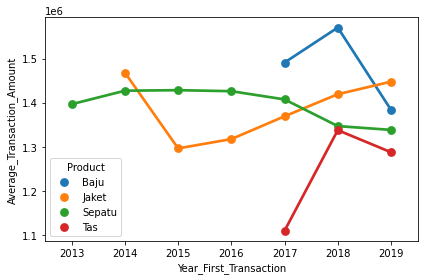

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
sns.pointplot(data = df.groupby(['Product', 'Year_First_Transaction']).mean().reset_index(), 
              x='Year_First_Transaction', 
              y='Average_Transaction_Amount', 
              hue='Product')
plt.tight_layout()
plt.show()

the average transaction for jackets and shoes was quite stagnant, but for clothes and bags significantly increased until 2018 and began to decline in 2019

### Proportion of churned customer for each product

<Figure size 432x288 with 0 Axes>

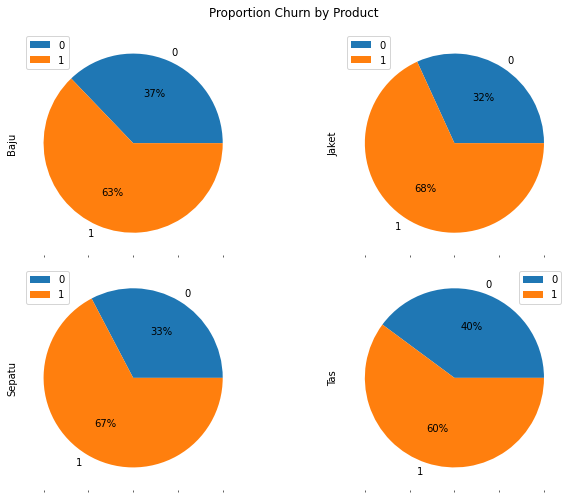

In [15]:
import matplotlib.pyplot as plt

plt.clf()
# Melakukan pivot data dengan pivot_table
df_piv = df.pivot_table(index='is_churn', 
                        columns='Product',
                        values='Customer_ID', 
                        aggfunc='count', 
                        fill_value=0)
# Plot pie chartnya
df_piv.plot.pie(subplots=True,
                figsize=(10, 7),
                layout=(-1, 2),
                autopct='%1.0f%%',
                title='Proportion Churn by Product')
plt.tight_layout()
plt.show()

as we can see, the number of churn customers is quite a lot, above 60% for each product.

### Customer Distribution by Count Transaction Group

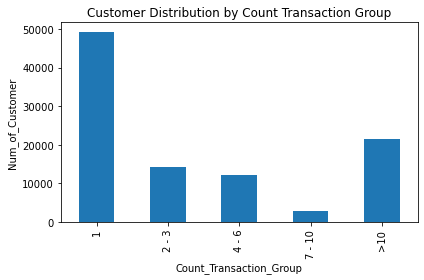

In [16]:
import matplotlib.pyplot as plt

plt.clf()
# Kategorisasi jumlah transaksi
def func(row):
    if row['Count_Transaction'] == 1:
        val = '1'
    elif (row['Count_Transaction'] >1 and row['Count_Transaction'] <= 3):
        val ='2 - 3'
    elif (row['Count_Transaction'] >3 and row['Count_Transaction'] <= 6):
        val ='4 - 6'
    elif (row['Count_Transaction'] >6 and row['Count_Transaction'] <= 10):
        val ='7 - 10'
    else:
        val ='>10'
    return val
# Tambahkan kolom baru
df['Count_Transaction_Group'] = df.apply(func, axis=1)

df_year = df.groupby(['Count_Transaction_Group'])['Customer_ID'].count()
df_year.plot(x='Count_Transaction_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Count Transaction Group')
plt.xlabel('Count_Transaction_Group')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()


Most of customers only buy 1 product.

### Customer Distribution by Average Transaction Amount Group

distribution of average transaction amount. This categorization is done by grouping the average transaction size

<Figure size 432x288 with 0 Axes>

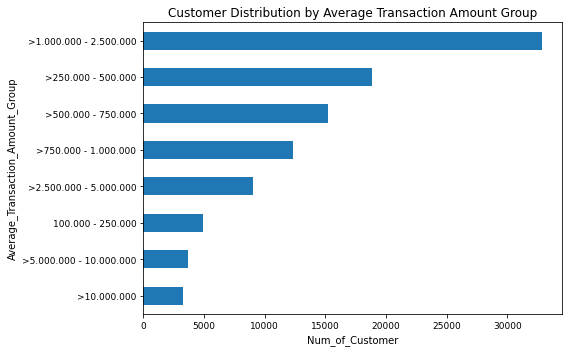

In [17]:
import matplotlib.pyplot as plt

plt.clf()
# Kategorisasi rata-rata besar transaksi
def f(row):
    if (row['Average_Transaction_Amount'] >= 100000 and row['Average_Transaction_Amount'] <=200000):
        val ='100.000 - 250.000'
    elif (row['Average_Transaction_Amount'] > 250000 and row['Average_Transaction_Amount'] <=500000 ):
        val ='>250.000 - 500.000'
    elif (row['Average_Transaction_Amount'] > 500000 and row['Average_Transaction_Amount'] <= 750000):
        val = '>500.000 - 750.000'
    elif (row['Average_Transaction_Amount'] > 750000 and row['Average_Transaction_Amount'] <=1000000):
        val = '>750.000 - 1.000.000'
    elif (row['Average_Transaction_Amount'] > 1000000 and row['Average_Transaction_Amount'] <=2500000):
        val = '>1.000.000 - 2.500.000'
    elif (row['Average_Transaction_Amount'] > 2500000 and row['Average_Transaction_Amount'] <=5000000):
        val = '>2.500.000 - 5.000.000'
    elif (row['Average_Transaction_Amount'] > 5000000 and row['Average_Transaction_Amount'] <=10000000):
        val = '>5.000.000 - 10.000.000'
    else:
        val = '>10.000.000'
    return val
# Tambahkan kolom baru
df['Average_Transaction_Amount_Group'] = df.apply(f, axis=1)

df_year = df.groupby(['Average_Transaction_Amount_Group'])['Customer_ID'].count().sort_values(ascending=True)
plt.figure(figsize=(8, 5))
df_year.plot(y='Average_Transaction_Amount_Group', x='Customer_ID', kind='barh',)
plt.title('Customer Distribution by Average Transaction Amount Group')
plt.ylabel('Average_Transaction_Amount_Group')
plt.xlabel('Num_of_Customer')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()
plt.show()

From the graph above, it turns out that most customers have a fairly large number of transactions, 1 million- 2.5 million

In [18]:
# Feature column: Year_Diff
df['Year_Diff']=df['Year_Last_Transaction']-df['Year_First_Transaction']

In [19]:
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']

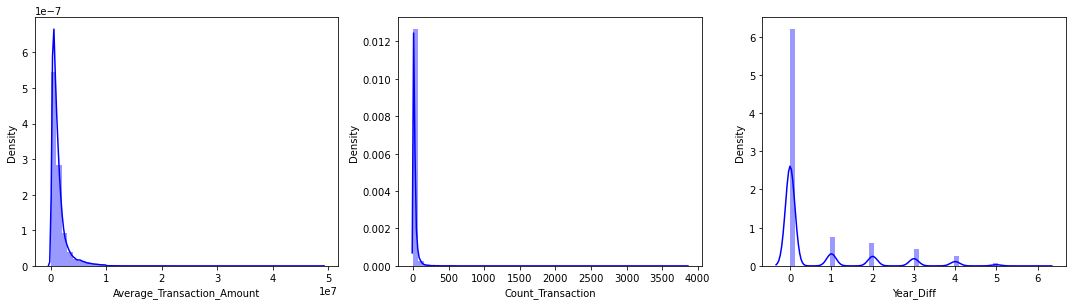

In [20]:
plt.figure(figsize=(15, 12))
for i in range(0, len(feature_columns)):
    plt.subplot(3, len(feature_columns), i+1)
    sns.distplot(df[feature_columns[i]], color='blue')
    plt.tight_layout()

## Treatment Outliers with Log Transform

In [21]:
for var in feature_columns:
    df[var]= (df[var]+1).apply(np.log)

because there are many outliers in the data, we use log transform to change data distribution to be more normal.

## Scaling

In [22]:
from sklearn.preprocessing import RobustScaler
for var in feature_columns:
    df[var]= RobustScaler().fit_transform(df[var].values.reshape(len(df), 1))

# Modelling

## Feature Columns dan Target

features that will be used for modeling are Average_Transaction_Amount, Count_Transaction, and Year_Diff. is_churn column is used for the target. Split training data and testing data with ratio 80:20

In [23]:
X = df[feature_columns]
y = df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [24]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.77
Precision (Test Set): 0.78
Recall (Test Set): 0.92
F1-Score (Test Set): 0.84
AUC: 0.69


### Visualisasi Confusion Matrix

The previous confusion matrix can be visualized using a heatmap from seaborn.

In [25]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[ 3133  3530]
 [ 1096 12241]]


<Figure size 432x288 with 0 Axes>

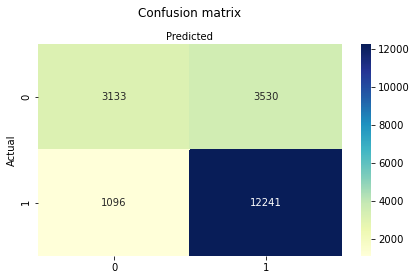

In [26]:
plt.clf()
# name of classes
class_names = [0, 1]
fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [27]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 0.7663
Test score:0.7687


Accuracy scores of training data and testing data are quite similar, so it is concluded that there is no overfitting

# Conclusion and Recommendation

- trend the number of customers increasing every year until 2017 and then starting to decline until 2019
- the number of transactions also tends to increase every year, but has decreased significantly in 2018 and 2019
- most customers only buy 1 product but with a price range of 1 million-2.5 million
- the percentage of customers who churn above 60% in each product.
- From the results above, recommendations can be made:
    - stores can collect customer data that is predicted to churn early so discounts or attractive promos can be given to keep customers from churn         and continue to transact.